In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.4.0+cpu
2.4.0+cpu
cpu


In [3]:
from typing import List

import IPython
import matplotlib.pyplot as plt

### Creating the pipeline

In [4]:
from torchaudio.pipelines import MMS_FA as bundle

model = bundle.get_model()
model.to(device)

tokenizer = bundle.get_tokenizer()
aligner = bundle.get_aligner()

Downloading: "https://dl.fbaipublicfiles.com/mms/torchaudio/ctc_alignment_mling_uroman/model.pt" to /root/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 1.18G/1.18G [00:04<00:00, 282MB/s] 


In [5]:
print(bundle.get_dict())

{'-': 0, 'a': 1, 'i': 2, 'e': 3, 'n': 4, 'o': 5, 'u': 6, 't': 7, 's': 8, 'r': 9, 'm': 10, 'k': 11, 'l': 12, 'd': 13, 'g': 14, 'h': 15, 'y': 16, 'b': 17, 'p': 18, 'w': 19, 'c': 20, 'v': 21, 'j': 22, 'z': 23, 'f': 24, "'": 25, 'q': 26, 'x': 27, '*': 28}


In [6]:
def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
    with torch.inference_mode():
        emission, _ = model(waveform.to(device))
        token_spans = aligner(emission[0], tokenizer(transcript))
    return emission, token_spans

We also define utility functions for plotting the result and previewing the audio segments.

In [7]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start, t_spans[-1].end
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    fig.tight_layout()

In [9]:
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)

### Normalizing the transcript

The transcripts passed to the pipeline must be normalized beforehand. The exact process of normalization depends on language.

Languages that do not have explicit word boundaries (such as Chinese, Japanese and Korean) require segmentation first. There are dedicated tools for this, but let’s say we have segmented transcript.

The first step of normalization is romanization. uroman is a tool that supports many languages.

Here is a BASH commands to romanize the input text file and write the output to another text file using uroman.

In [10]:
! echo "des événements d'actualité qui se sont produits durant l'année 1882" > text.txt

In [18]:
!/kaggle/working/< text.txt > text_romanized.txt

/bin/bash: uroman/kaggle/working/: No such file or directory


In [17]:
!cat text_romanized.txt

In [19]:
import re


def normalize_uroman(text):
    text = text.lower()
    text = text.replace("’", "'")
    text = re.sub("([^a-z' ])", " ", text)
    text = re.sub(' +', ' ', text)
    return text.strip()


with open("text_romanized.txt", "r") as f:
    for line in f:
        text_normalized = normalize_uroman(line)
        print(text_normalized)

### Aligning transcripts to speech

### German

In [20]:
text_raw = "aber seit ich bei ihnen das brot hole"
text_normalized = "aber seit ich bei ihnen das brot hole"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/10349_8674_000087.flac"
waveform, sample_rate = torchaudio.load(
    url, frame_offset=int(0.5 * bundle.sample_rate), num_frames=int(2.5 * bundle.sample_rate)
)

In [21]:
assert sample_rate == bundle.sample_rate

Raw Transcript:  aber seit ich bei ihnen das brot hole
Normalized Transcript:  aber seit ich bei ihnen das brot hole


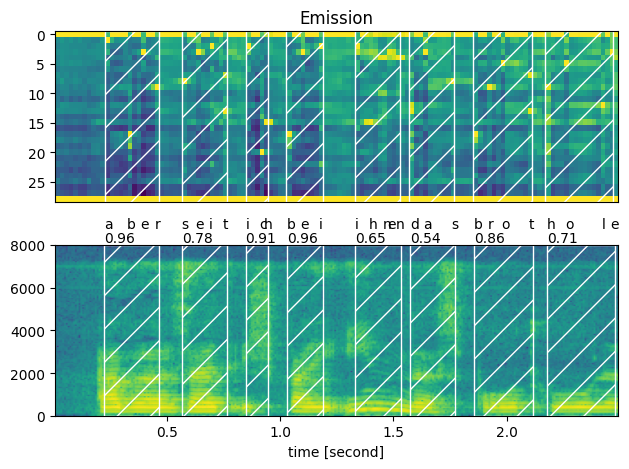

In [22]:
transcript = text_normalized.split()
tokens = tokenizer(transcript)

emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [23]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

aber (0.96): 0.222 - 0.464 sec


In [24]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

seit (0.78): 0.565 - 0.766 sec


In [25]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

ich (0.91): 0.847 - 0.948 sec


In [26]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

bei (0.96): 1.028 - 1.190 sec


In [27]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

ihnen (0.65): 1.331 - 1.532 sec


In [28]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

das (0.54): 1.573 - 1.774 sec


In [29]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

brot (0.86): 1.855 - 2.117 sec


In [30]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

hole (0.71): 2.177 - 2.480 sec


### Chinese

Chinese is a character-based language, and there is not explicit word-level tokenization (separated by spaces) in its raw written form. In order to obtain word level alignments, you need to first tokenize the transcripts at the word level using a word tokenizer like “Stanford Tokenizer”. However this is not needed if you only want character-level alignments.

In [31]:
text_raw = "关 服务 高端 产品 仍 处于 供不应求 的 局面"
text_normalized = "guan fuwu gaoduan chanpin reng chuyu gongbuyingqiu de jumian"

In [32]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/mvdr/clean_speech.wav"
waveform, sample_rate = torchaudio.load(url)
waveform = waveform[0:1]

In [33]:
assert sample_rate == bundle.sample_rate

Raw Transcript:  关 服务 高端 产品 仍 处于 供不应求 的 局面
Normalized Transcript:  guan fuwu gaoduan chanpin reng chuyu gongbuyingqiu de jumian


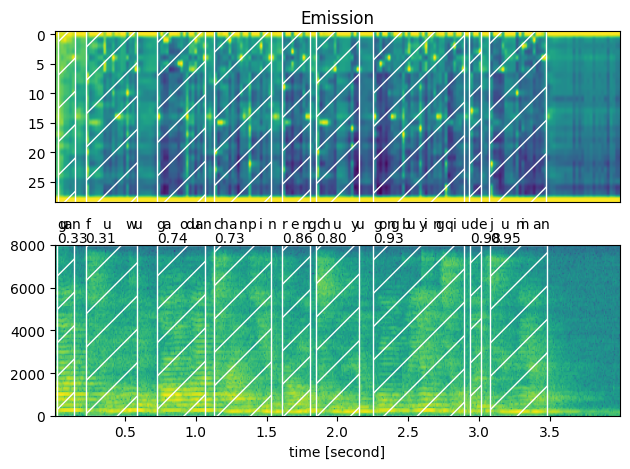

In [34]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [35]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

guan (0.33): 0.020 - 0.141 sec


In [36]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

fuwu (0.31): 0.221 - 0.583 sec


In [37]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

gaoduan (0.74): 0.724 - 1.065 sec


In [38]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

chanpin (0.73): 1.126 - 1.528 sec


In [39]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

reng (0.86): 1.608 - 1.809 sec


In [40]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

chuyu (0.80): 1.849 - 2.151 sec


In [41]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

gongbuyingqiu (0.93): 2.251 - 2.894 sec


In [42]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

de (0.98): 2.935 - 3.015 sec


In [43]:
preview_word(waveform, token_spans[8], num_frames, transcript[8])

jumian (0.95): 3.075 - 3.477 sec


### Polish

In [44]:
text_raw = "wtedy ujrzałem na jego brzuchu okrągłą czarną ranę"
text_normalized = "wtedy ujrzalem na jego brzuchu okragla czarna rane"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/5090_1447_000088.flac"
waveform, sample_rate = torchaudio.load(url, num_frames=int(4.5 * bundle.sample_rate))

In [45]:
assert sample_rate == bundle.sample_rate

Raw Transcript:  wtedy ujrzałem na jego brzuchu okrągłą czarną ranę
Normalized Transcript:  wtedy ujrzalem na jego brzuchu okragla czarna rane


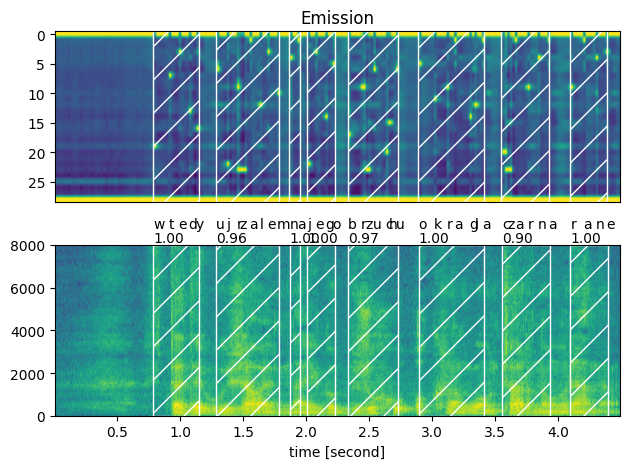

In [46]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [47]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

wtedy (1.00): 0.783 - 1.145 sec


In [48]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

ujrzalem (0.96): 1.286 - 1.788 sec


In [49]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

na (1.00): 1.868 - 1.949 sec


In [50]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

jego (1.00): 2.009 - 2.230 sec


In [51]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

brzuchu (0.97): 2.330 - 2.732 sec


In [52]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

okragla (1.00): 2.893 - 3.415 sec


In [53]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

czarna (0.90): 3.556 - 3.938 sec


In [54]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

rane (1.00): 4.098 - 4.399 sec


### Portuguese

In [55]:
text_raw = "na imensa extensão onde se esconde o inconsciente imortal"
text_normalized = "na imensa extensao onde se esconde o inconsciente imortal"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/6566_5323_000027.flac"
waveform, sample_rate = torchaudio.load(
    url, frame_offset=int(bundle.sample_rate), num_frames=int(4.6 * bundle.sample_rate)
)

In [56]:
assert sample_rate == bundle.sample_rate

Raw Transcript:  na imensa extensão onde se esconde o inconsciente imortal
Normalized Transcript:  na imensa extensao onde se esconde o inconsciente imortal


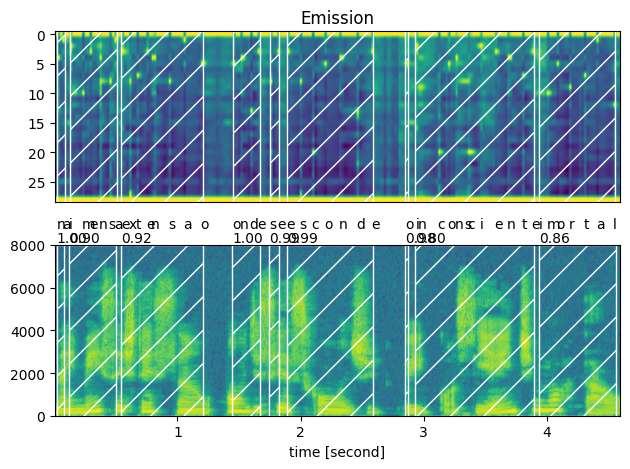

In [57]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [58]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

na (1.00): 0.020 - 0.080 sec


In [59]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

imensa (0.90): 0.120 - 0.502 sec


In [60]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

extensao (0.92): 0.542 - 1.205 sec


In [61]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

onde (1.00): 1.446 - 1.667 sec


In [62]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

se (0.99): 1.748 - 1.828 sec


In [63]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

esconde (0.99): 1.888 - 2.591 sec


In [64]:
preview_word(waveform, token_spans[6], num_frames, transcript[6])

o (0.98): 2.852 - 2.872 sec


In [65]:
preview_word(waveform, token_spans[7], num_frames, transcript[7])

inconsciente (0.80): 2.933 - 3.897 sec


In [66]:
preview_word(waveform, token_spans[8], num_frames, transcript[8])

imortal (0.86): 3.937 - 4.560 sec


### Italian

In [67]:
text_raw = "elle giacean per terra tutte quante"
text_normalized = "elle giacean per terra tutte quante"

url = "https://download.pytorch.org/torchaudio/tutorial-assets/642_529_000025.flac"
waveform, sample_rate = torchaudio.load(url, num_frames=int(4 * bundle.sample_rate))

In [68]:
assert sample_rate == bundle.sample_rate

Raw Transcript:  elle giacean per terra tutte quante
Normalized Transcript:  elle giacean per terra tutte quante


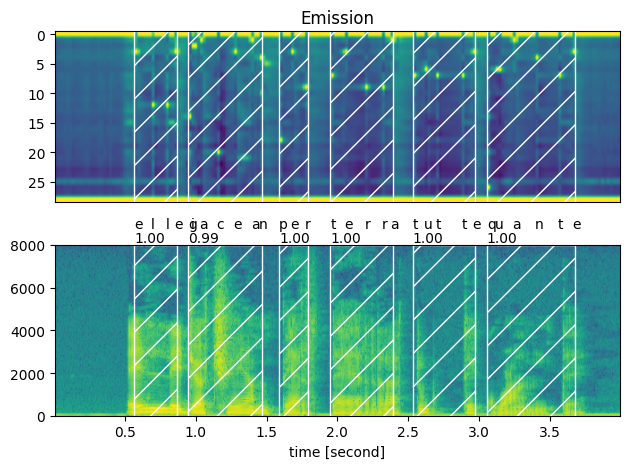

In [69]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)

In [70]:
preview_word(waveform, token_spans[0], num_frames, transcript[0])

elle (1.00): 0.563 - 0.864 sec


In [71]:
preview_word(waveform, token_spans[1], num_frames, transcript[1])

giacean (0.99): 0.945 - 1.467 sec


In [72]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

per (1.00): 1.588 - 1.789 sec


In [73]:
preview_word(waveform, token_spans[3], num_frames, transcript[3])

terra (1.00): 1.950 - 2.392 sec


In [74]:
preview_word(waveform, token_spans[4], num_frames, transcript[4])

tutte (1.00): 2.533 - 2.975 sec


In [75]:
preview_word(waveform, token_spans[5], num_frames, transcript[5])

quante (1.00): 3.055 - 3.678 sec
